# Movie Recommendations using RBMs

## Get the data

In [1]:
from zipfile import ZipFile
with ZipFile('ml-latest-small.zip', 'r') as _zip:
    _zip.printdir()
    print('Extracting all the files now...')
    _zip.extractall()
    print('Done!')

File Name                                             Modified             Size
ml-latest-small/                               2018-09-26 15:50:12            0
ml-latest-small/links.csv                      2018-09-26 15:50:10       197979
ml-latest-small/tags.csv                       2018-09-26 15:49:40       118660
ml-latest-small/ratings.csv                    2018-09-26 15:49:38      2483723
ml-latest-small/README.txt                     2018-09-26 15:50:12         8342
ml-latest-small/movies.csv                     2018-09-26 15:49:56       494431
Extracting all the files now...
Done!


In [2]:
# importing useful libraries
import pandas as pd
import numpy as np
import tensorflow as tf
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
print(len(movies))
movies.head()

9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


There are exactly 9,742 rated movies with their title and their genre stored in the `movies` data.

In [4]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
print("Total of unique IDs: ", len(ratings.userId.unique()))
print("Rating scores: ", ratings.rating.unique())

Total of unique IDs:  610
Rating scores:  [4.  5.  3.  2.  1.  4.5 3.5 2.5 0.5 1.5]


The `ratings` data stores 610 unique User ID number, the movie's ID that the user has watched, the user's rating to said movie (from 0.5 to 5) and when the user rated that movie.

## Build up the Restricted Boltzmann Machine model

As we know, a RBM model has two layers - a visible (or input) layer and a hidden layer:
- For our model, the visible layer is going to contain X neurons, where X is the amount of movies in the `movies` dataset. Each neuron will possess a normalized rating value from 0 to 1, where 0 meaning that a user has not watched that movie and the closer the value is to 1, the more the user likes the movie.
- After passing in the input, we train the RBM on it and have the hidden layer learn its features. These features are what we use to reconstruct the input, which will predict the ratings for movies that a user hasn't watched, which is useful to recommend movies.

In [6]:
# Formating the data into input for the RBM
user_rating_df = ratings.pivot_table(index='userId', columns='movieId', values="rating", dropna=False)
user_rating_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Normalizing user ratings
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
inputX = norm_user_rating_df.values
inputX[0:5]

array([[0.8, 0. , 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

**Setting the Model's Parameters** 

In [8]:
# Creating vb, a placeholder for visible layer with bias = number of unique movies 
v_neurons = len(user_rating_df.columns)
vb = tf.placeholder("float", [v_neurons])

# Creating hb, a placeholder for hidden layer with bias = 1000 (the choice of neurons numbers is arbitrary)
h_neurons = 1000
hb = tf.placeholder("float", [h_neurons])

# Creating W, weights that connects the hidden layer with the visible layer
W = tf.placeholder("float", [v_neurons, h_neurons])

Next, I will create the visible and hidden layer units and set their activation functions. In this case, I will be using the `tf.sigmoid` and `tf.relu` functions as nonlinear activations. 

In [9]:
# Phase 1: Input processing
v0 = tf.placeholder("float", [None, v_neurons])  # [?x9724]
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)       # [?x1000]
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) # [?x1000]

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)           # [?x9724]
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))   # [?x9724]
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)      # [?x1000]

Now, let's set the RBM training parameters and functions.

In [10]:
# learning rate
alpha = 1.0

# Creating the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Contrastive Divergene to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Creating methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use tf.cast instead.


Calculate the error function, which in this case will be the Mean Absolute Error function.

In [11]:
error = tf.reduce_mean(tf.square(v0 - v1))

Now, it's time to initialize the variables.

In [12]:
# Current weight
cur_w = np.zeros([v_neurons, h_neurons], "float32")
# Current visible unit biases
cur_vb = np.zeros([v_neurons], "float32")
# Current hidden unit biases
cur_hb = np.zeros([h_neurons], "float32")
# Previous weight
prv_w = np.zeros([v_neurons, h_neurons], "float32")
# Previous visible unit biases
prv_vb = np.zeros([v_neurons], "float32")
# Previous hidden unit biases
prv_hb = np.zeros([h_neurons], "float32")
session = tf.Session()
session.run(tf.global_variables_initializer())

## Training the RBM

Now we train the RBM with 20 epochs, with each epoch using 10 batches with size 100. After training, we print out a graph with the error by epoch. 

0.14988108
0.09268754
0.06923484
0.05507606
0.04829058
0.041266724
0.037963964
0.034627065
0.032269806
0.028133856
0.025928386
0.024399381
0.022992965
0.022547677
0.02154603
0.021058988
0.01988622
0.019727234
0.01922785
0.01886298


<IPython.core.display.Javascript object>


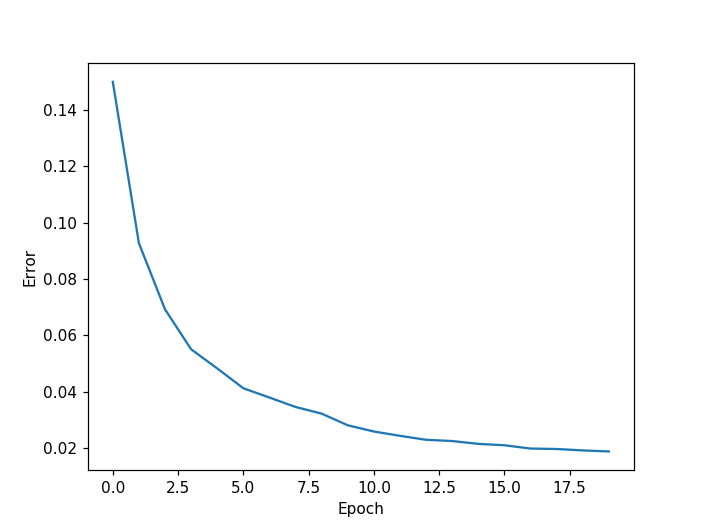

In [13]:
epochs = 20
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(inputX), batchsize), range(batchsize, len(inputX), batchsize) ):
        batch = inputX[start:end]
        fd = {v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb}
        cur_w = session.run(update_w, feed_dict=fd)
        cur_vb = session.run(update_vb, feed_dict=fd)
        cur_hb = session.run(update_hb, feed_dict=fd)
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(session.run(error, feed_dict=fd))
    print(errors[-1])

plt.plot(errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

## Recommandation

We can now predict movies that an arbitrarily selected user might like. Let's suppose that the user number **450** need some recommandations.

In [21]:
user_id = 450

In [22]:
# Selecting the input user
inputUser = inputX[user_id - 1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [23]:
# Feeding in the user and reconstructing the input
user_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
user_v1 = tf.nn.sigmoid(tf.matmul(user_h0, tf.transpose(W)) + vb)
feed = session.run(user_h0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = session.run(user_v1, feed_dict={user_h0: feed, W: prv_w, vb: prv_vb})

In [24]:
print(rec)

[[0.40760303 0.20440543 0.08305874 ... 0.00468397 0.00421473 0.00463012]]


In [25]:
# listing the 20 most recommended movies for the user 303 
scored_movies_user = movies[movies['movieId'].isin(user_rating_df.columns)].copy()
scored_movies_user['RecommendationScore'] = rec[0]
scored_movies_user.sort_values('RecommendationScore', ascending=False).head(20)

,movieId,title,genres,RecommendationScore
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.641910
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.551669
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.538458
1939,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.503006
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.500328
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.433892
2226,2959,Fight Club (1999),Action|Crime|Drama|Thriller,0.421507
461,527,Schindler's List (1993),Drama|War,0.410691
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.407603
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.403387


In [26]:
# Find all the movies that the user 500 has watched before
movies_user_500 = ratings[ratings['userId'] == user_id]
movies_user_500.head()

,userId,movieId,rating,timestamp
70557,450,70,2.0,974705218
70558,450,110,5.0,974704570
70559,450,111,4.0,974705774
70560,450,260,5.0,974705741
70561,450,358,3.0,974704570


In [27]:
# Merge all the movies that the user 500 has watched with the predicted scores based on his historical data
merge_df_user_500 = scored_movies_user.merge(movies_user_500, on='movieId', how='outer')

# Show the first 20 rows
merge_df_user_500.sort_values('RecommendationScore', ascending=False).head(20)

,movieId,title,genres,RecommendationScore,userId,rating,timestamp
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War,0.641910,NaN,NaN,NaN
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.551669,450.0,5.0,974705741.0
277,318,"Shawshank Redemption, The (1994)",Crime|Drama,0.538458,NaN,NaN,NaN
1938,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.503006,NaN,NaN,NaN
510,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.500328,NaN,NaN,NaN
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.433892,NaN,NaN,NaN
2224,2959,Fight Club (1999),Action|Crime|Drama|Thriller,0.421507,NaN,NaN,NaN
461,527,Schindler's List (1993),Drama|War,0.410691,NaN,NaN,NaN
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.407603,NaN,NaN,NaN
615,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller,0.403387,NaN,NaN,NaN


The 2 most recommended movies for the user 450 are `Forest Gump (1994)` and `The Shawshank Redemption (1994)`, whose recommendation scores are greater then 0.5 (0.64 and 0.54 respectively).